#**Deep Convolutional ACGAN (Auxiliary Classifier GAN)**

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.utils as utils
import torch.optim as optim 
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.autograd import Variable

import matplotlib.pyplot as plt
import numpy as np

In [2]:
workers = 2
batch_size = 64

nc = 1    # number of channel
nz = 100  # dimension of latent vector z
ngf = 64  # number of features of generator
ndf = 64  # number of features of discriminator

epochs = 50
lr = 0.0002
beta1 = 0.5
isCuda = True

device = torch.device("cuda:0" if (torch.cuda.is_available() and isCuda) else "cpu")

In [3]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,))])
dataset = datasets.MNIST('../data', train=True, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

test_dataset = datasets.MNIST('../data', train=False, download=True, transform=transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=workers)

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


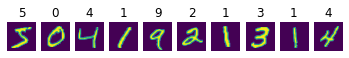

In [4]:
fig = plt.figure()

for i in range(10):
  train_x = dataset.data[i]
  train_y = dataset.targets[i]

  ax = fig.add_subplot(1, 10, i+1)
  ax.imshow(train_x)
  ax.set_title(str(train_y.item()))
  ax.axis("off")

plt.show()

## Generator

[nz, 1, 1] → [4ngf, 4, 4] → [2ngf, 7, 7] → [ngf, 14, 14] → [1, 28, 28]

In [5]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    self.embedding = nn.Embedding(num_embeddings=10, embedding_dim=nz)
    self.main = nn.Sequential(
        nn.ConvTranspose2d(nz, 4*ngf, 4, 1, 0, bias=False),
        nn.BatchNorm2d(4*ngf),
        nn.ReLU(inplace=True),

        nn.ConvTranspose2d(4*ngf, 2*ngf, 3, 2, 1, bias=False),
        nn.BatchNorm2d(2*ngf),
        nn.ReLU(inplace=True),

        nn.ConvTranspose2d(2*ngf, ngf, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ngf),
        nn.ReLU(inplace=True),

        nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
        nn.Tanh()
    )

  def forward(self, x, y):
    embed = self.embedding(y)
    z = x * torch.unsqueeze(torch.unsqueeze(embed,2),3)
    return self.main(z)

## Discriminator
[1, 28, 28] → [ndf, 14, 14] → [2ndf, 7, 7] → [4ndf, 4, 4] → [1], [10]

In [6]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.main = nn.Sequential(
        nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(ndf, 2*ndf, 4, 2, 1, bias=False),
        nn.BatchNorm2d(2*ndf),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(2*ndf, 4*ndf, 3, 2, 1, bias=False),
        nn.BatchNorm2d(4*ndf),
        nn.LeakyReLU(0.2, inplace=True),
    )
    self.real_or_fake = nn.Sequential(
        nn.Linear(64*ndf, 1),
        nn.Sigmoid()
    )
    self.classification = nn.Sequential(
        nn.Linear(64*ndf, 10),
        nn.Softmax(dim=1)
    )

  def forward(self, x):
    x = torch.flatten(self.main(x), 1)
    r = self.real_or_fake(x)
    c = self.classification(x)
    return r, c

## Making models & Weight initialization

In [7]:
def weights_init(m):
  classname = m.__class__.__name__
  if classname.find('Conv') != -1:
    nn.init.normal_(m.weight.data, 0.0, 0.02)
  elif classname.find('BatchNorm') != -1:
    nn.init.normal_(m.weight.data, 1.0, 0.02)
    nn.init.constant_(m.bias.data, 0)

netG = Generator().to(device)
netD = Discriminator().to(device)

netG.apply(weights_init)
netD.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (real_or_fake): Sequential(
    (0): Linear(in_features=4096, out_features=1, bias=True)
    (1): Sigmoid()
  )
  (classification): Sequential(
    (0): Linear(in_features=4096, out_features=10, bias=True)
    (1): Softmax(dim=1)
  )
)

## (Option) Load from drive


In [8]:
import pickle
img_list_path = "/content/drive/MyDrive/Colab Notebooks/AirForce/model/ACGAN_v1_img_list.txt"
with open(img_list_path, 'rb') as f:
  img_list = pickle.load(f)

G_save_name = 'ACGAN_v1_G.pt'
D_save_name = 'ACGAN_v1_D.pt'
G_path = F"/content/drive/MyDrive/Colab Notebooks/AirForce/model/{G_save_name}"
D_path = F"/content/drive/MyDrive/Colab Notebooks/AirForce/model/{D_save_name}"

netG.load_state_dict(torch.load(G_path))
netD.load_state_dict(torch.load(D_path))

<All keys matched successfully>

## Loss Functions and Optimizers


In [9]:
fixed_noise = torch.randn(100, nz, 1, 1, device=device)
fixed_label = torch.zeros((100,), dtype=torch.long, device=device)
for i in range(10):
  for j in range(10):
    fixed_label[j+i*10] = i

real_label = 1
fake_label = 0

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1,0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1,0.999))

## Training

In [ ]:
img_list, G_b_losses, G_c_losses, D_b_losses, D_c_losses = [], [], [], [], []
iters = 0

netD.train()
netG,train()
for ep in range(epochs):
  for batch_idx, (image, lbl) in enumerate(dataloader, 0):
    # 1. Update Discriminator
    # 1-1. Train with Real Batch
    netD.zero_grad()
    b_size = image.shape[0]
    image = Variable(image).cuda()
    label = torch.full((b_size,), real_label, device=device)
    label = label.type(torch.cuda.FloatTensor)

    lbl = Variable(lbl).cuda()

    output, classes = netD(image)
    errD_real_b = 0.5 * torch.mean((output-label)**2)
    errD_real_c = F.nll_loss(classes, lbl)
    errD_real = errD_real_b + errD_real_c
    errD_real.backward()
    D_x = output.mean().item()

    # 1-2. Train with Fake Batch
    noise = torch.randn(b_size, nz, 1, 1, device=device)
    fake = netG(noise, lbl)
    label.fill_(fake_label)

    output, classes = netD(fake.detach())
    errD_fake_b = 0.5 * torch.mean((output-label)**2)
    errD_fake_c = F.nll_loss(classes, lbl)
    errD_fake = errD_fake_b + errD_fake_c
    errD_fake.backward()
    D_G_z1 = output.mean().item()
    errD_b = errD_real_b + errD_fake_b
    errD_c = 0.5 * (errD_real_c + errD_fake_c)
    optimizerD.step()
    
    # 2. Update Generator
    netG.zero_grad()
    label.fill_(real_label)

    output, classes = netD(fake)
    errG_b = 0.5 * torch.mean((output - label)**2)
    errG_c = F.nll_loss(classes, lbl)
    errG = errG_b + errG_c
    errG.backward()
    D_G_z2 = output.mean().item()
    optimizerG.step()

    if batch_idx % 50 == 49:
      print('[%2d/%2d][%3d/%d]\tLoss_D: %.4f/%.4f\tLoss_G: %.4f/%.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f' 
            % (ep+1, epochs, batch_idx+1, len(dataloader), 
               errD_b.item(), errD_c.item(), errG_b.item(), errG_c.item(), D_x, D_G_z1, D_G_z2))
      G_b_losses.append(errG_b.item())
      G_c_losses.append(errG_c.item())
      D_b_losses.append(errD_b.item())
      D_c_losses.append(errD_c.item())
      if (iters % 100 == 0) or ((ep == epochs-1) and (batch_idx == len(dataloader)-1)): 
        with torch.no_grad():
          fake = netG(fixed_noise, fixed_label).detach().cpu()
        img_list.append(fake)
      iters += 1

[ 1/50][ 50/938]	Loss_D: 0.0443/-0.4771	Loss_G: 0.3994/-0.2459	D(x): 0.8418	D(G(z)): 0.1734 / 0.1089
[ 1/50][100/938]	Loss_D: 0.0132/-0.7421	Loss_G: 0.4294/-0.6552	D(x): 0.9110	D(G(z)): 0.1041 / 0.0744
[ 1/50][150/938]	Loss_D: 0.0272/-0.8202	Loss_G: 0.4785/-0.7597	D(x): 0.9635	D(G(z)): 0.1921 / 0.0219
[ 1/50][200/938]	Loss_D: 0.0100/-0.7978	Loss_G: 0.4542/-0.7931	D(x): 0.9259	D(G(z)): 0.0740 / 0.0478
[ 1/50][250/938]	Loss_D: 0.0138/-0.8936	Loss_G: 0.4254/-0.8696	D(x): 0.9322	D(G(z)): 0.1135 / 0.0795
[ 1/50][300/938]	Loss_D: 0.0117/-0.8548	Loss_G: 0.4327/-0.9158	D(x): 0.8920	D(G(z)): 0.0665 / 0.0710
[ 1/50][350/938]	Loss_D: 0.0138/-0.9276	Loss_G: 0.4376/-0.9543	D(x): 0.9433	D(G(z)): 0.1234 / 0.0656
[ 1/50][400/938]	Loss_D: 0.0166/-0.9520	Loss_G: 0.4463/-0.9604	D(x): 0.9502	D(G(z)): 0.1418 / 0.0561
[ 1/50][450/938]	Loss_D: 0.0090/-0.8963	Loss_G: 0.4567/-0.9256	D(x): 0.9341	D(G(z)): 0.0900 / 0.0449
[ 1/50][500/938]	Loss_D: 0.0081/-0.9485	Loss_G: 0.4263/-0.9711	D(x): 0.9373	D(G(z)): 0.0860

### Check last fake images

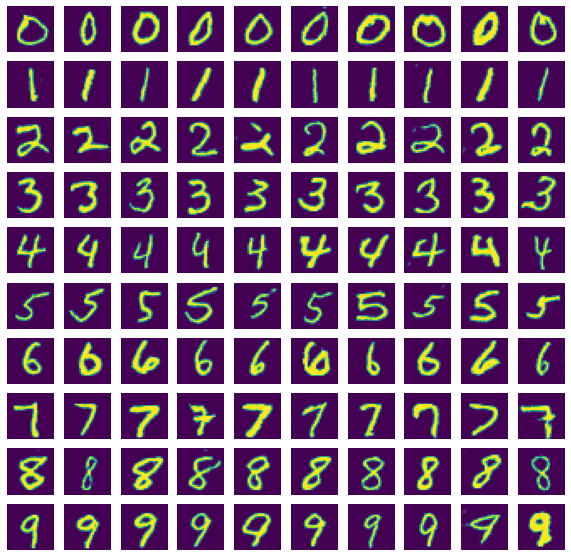

In [ ]:
fig = plt.figure(figsize=(10,10))

imgs = img_list[-1].tolist()
for i in range(10):
  for j in range(10):
    img = imgs[10*i+j][0]
    ax = fig.add_subplot(10, 10, 10*i+j+1)
    ax.imshow(img)
    ax.axis("off")

plt.show()

### Plot losses of generator and discriminator

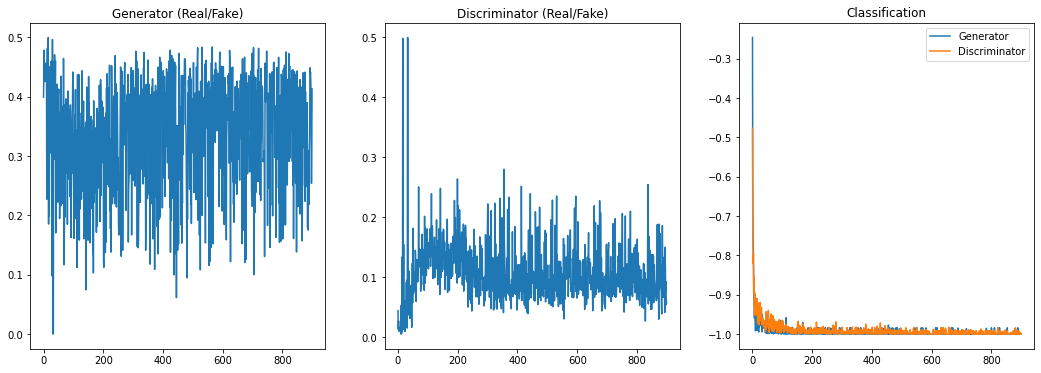

In [ ]:
fig = plt.figure(figsize=(18, 6))

ax = fig.add_subplot(1, 3, 1)
ax.plot(range(len(G_b_losses)), G_b_losses)
ax.set_title("Generator (Real/Fake)")

ax = fig.add_subplot(1, 3, 2)
ax.plot(range(len(D_b_losses)), D_b_losses)
ax.set_title("Discriminator (Real/Fake)")

ax = fig.add_subplot(1, 3, 3)
ax.set_title("Classification")
ax.plot(range(len(G_c_losses)), G_c_losses, label='Generator')
ax.plot(range(len(D_c_losses)), D_c_losses, label='Discriminator')
ax.legend()

plt.show()

### Save models and images in drive

In [ ]:
G_save_name = 'ACGAN_v1_G.pt'
D_save_name = 'ACGAN_v1_D.pt'
G_path = F"/content/drive/MyDrive/Colab Notebooks/AirForce/model/{G_save_name}"
D_path = F"/content/drive/MyDrive/Colab Notebooks/AirForce/model/{D_save_name}"

torch.save(netG.state_dict(), G_path)
torch.save(netD.state_dict(), D_path)

In [ ]:
import pickle
img_list_path = "/content/drive/MyDrive/Colab Notebooks/AirForce/model/ACGAN_v1_img_list.txt"
with open(img_list_path, 'wb') as f:
  pickle.dump(img_list, f)

## How generator improved

### Plot

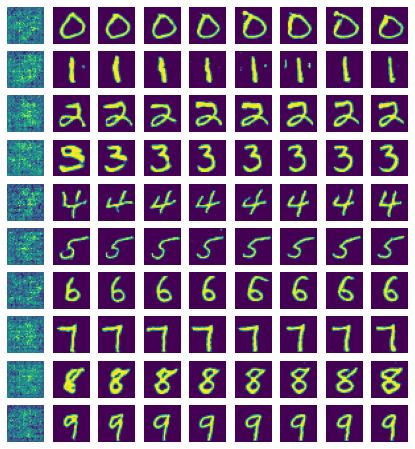

In [ ]:
n_img_set = len(img_list)
SIZE = 8

fig = plt.figure(figsize=(SIZE*n_img_set/10.0, SIZE))

for k in range(n_img_set):
  imgs = img_list[k].tolist()
  for j in range(10):
    img = imgs[j*10][0]
    ax = fig.add_subplot(10, n_img_set, k+j*n_img_set+1)
    ax.imshow(img)
    ax.axis("off")

plt.show()

### Animation

In [ ]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, clear_output

ims = []
SIZE = 10
fig = plt.figure(figsize=(SIZE, SIZE))

imgs = img_list[0].tolist()
for j in range(100):
  ax = fig.add_subplot(10, 10, j+1)
  im = ax.imshow(imgs[j][0])
  ax.axis("off")
  ims.append(im)

def init():
  for j in range(100):
    ims[j].set_data(([[]*10]*10))

  return tuple(ims)

def update(frame):
  imgs = img_list[frame].tolist()
  
  for j in range(100):
    img = imgs[j][0]
    ims[j].set_array(img)

  return tuple(ims)

ani = FuncAnimation(fig=fig, init_func=init, func=update, interval=500, blit=True, frames=range(n_img_set))

plt.show()
clear_output(wait = True)

HTML(ani.to_jshtml())

## Test Classification with Discriminator

-Real/Fake: 34.2706%
-Classification: 9854/10000 (98.54%)
  0: 972/980 (99.1837%)
  1: 1129/1135 (99.4714%)
  2: 1014/1032 (98.2558%)
  3: 993/1010 (98.3168%)
  4: 980/982 (99.7963%)
  5: 881/892 (98.7668%)
  6: 946/958 (98.7474%)
  7: 1016/1028 (98.8327%)
  8: 946/974 (97.1253%)
  9: 977/1009 (96.8285%)


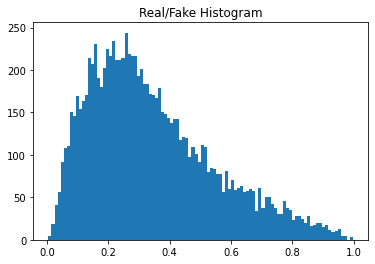

In [12]:
isReal = []
classifyRight = [0]*10
classifyWrong = [0]*10

netD.eval()
for batch_idx, (image, lbl) in enumerate(test_dataloader, 0):
  b_size = image.shape[0]

  image = Variable(image).cuda()
  output, classes = netD(image)
  classes = classes.cpu().detach().numpy()
  
  isReal = isReal + output.squeeze().tolist()
  for i in range(b_size):
    pred = np.argmax(classes[i])
    ans = lbl[i]
    if pred == ans:
      classifyRight[ans] += 1
    else:
      classifyWrong[ans] += 1

print('-Real/Fake: %.4f%%' % (100.0*sum(isReal)/len(isReal)))

right = sum(classifyRight)
wrong = sum(classifyWrong)
total = right + wrong

print('-Classification: %d/%d (%.2f%%)' % (right, total, 100.0*right/total))

for j in range(10):
  right = classifyRight[j]
  wrong = classifyWrong[j]
  total = right + wrong
  print('  %d: %d/%d (%.4f%%)' % (j, right, total, 100.0*right/total))

plt.hist(isReal, bins=100)
plt.title("Real/Fake Histogram")
plt.show()

## Make digits with same latent vector

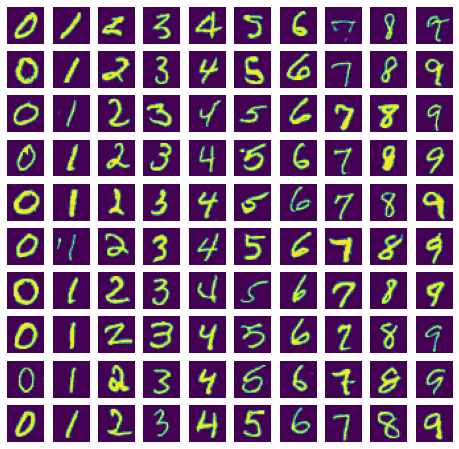

In [13]:
n_latent = 10
SIZE = 8

noise = torch.zeros(10*n_latent, nz, 1, 1, device=device)
temp_noise = torch.randn(n_latent, nz, 1, 1, device=device)
label = torch.zeros((10*n_latent,), dtype=torch.long, device=device)
for i in range(n_latent):
  for j in range(10):
    noise[j+i*10] = temp_noise[i]
    label[j+i*10] = j

imgs = netG(noise, label).detach().cpu().tolist()

fig = plt.figure(figsize=(SIZE*n_latent/10.0, SIZE))

for j in range(10*n_latent):
  img = imgs[j][0]
  ax = fig.add_subplot(n_latent, 10, j+1)
  ax.imshow(img)
  ax.axis("off")

plt.show()